In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# ---------- Load Data ----------
full_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/bd_building_feat-dist_dem_ghs.gpkg"
labeled_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/bd_building_only_labeled.gpkg"
gdf_labeled = gpd.read_file(labeled_path)

# Drop unnecessary columns
drop_cols = ['fid', 'org_fid', 'building_category']
gdf_labeled = gdf_labeled.drop(columns=[c for c in drop_cols if c in gdf_labeled.columns], errors='ignore')

# Target and Features
target_col = 'binary_category'
X = gdf_labeled.drop(columns=[target_col, 'geometry'], errors='ignore')
y = gdf_labeled[target_col]

# ---------- Handle binary mask columns ----------
binary_mask_cols = ['pop_missing', 'built-s_missing', 'ntl_missing', 'urban_index_missing']
if 'In_landuse_a' in X.columns:
    X['In_landuse_a'] = X['In_landuse_a'].astype(int)
for col in binary_mask_cols:
    if col in X.columns:
        X[col] = X[col].astype(int)

# ---------- Separate numeric and categorical ----------
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# ---------- Fill and encode ----------
for col in categorical_cols:
    X[col] = X[col].fillna('unknown').astype(str)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ---------- Train-Test Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ---------- Preprocessing Pipelines ----------
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# ---------- SMOTE + Logistic Regression Pipeline ----------
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000,
        solver='lbfgs', 
    ))
])

# ---------- Grid Search ----------
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# ---------- Train ----------
print("Training Logistic Regression with SMOTE and OneHotEncoding...")
grid_search.fit(X_train, y_train)
print(f"\n✅ Best Parameters: {grid_search.best_params_}")
print(f"✅ Best F1-score (CV): {grid_search.best_score_:.4f}")

# ---------- Evaluate ----------
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n--- Classification Report (on Test Set) ---")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

print("✅ Done.")

# ---------- Save Model ----------
model_bundle = {
    'model': best_model,
    'label_encoder': le,
    'features': X.columns.tolist(),
    'categorical_features': categorical_cols
}

model_save_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/lr_files/NOpsudo_lr_model.joblib"
joblib.dump(model_bundle, model_save_path)
print(f"✅ Model saved to: {model_save_path}")


Training Logistic Regression with SMOTE and OneHotEncoding...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

✅ Best Parameters: {'classifier__C': 10, 'classifier__penalty': 'l2'}
✅ Best F1-score (CV): 0.8888

--- Classification Report (on Test Set) ---
                 precision    recall  f1-score   support

non_residential       0.50      0.76      0.60      3084
    residential       0.95      0.84      0.89     14872

       accuracy                           0.83     17956
      macro avg       0.72      0.80      0.75     17956
   weighted avg       0.87      0.83      0.84     17956

--- Confusion Matrix ---
[[ 2358   726]
 [ 2373 12499]]
✅ Done.
✅ Model saved to: D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/lr_files/NOpsudo_lr_model.joblib


In [2]:
import geopandas as gpd
import numpy as np
import fiona
import joblib
import pandas as pd
import heapq

# ------------------------------
# Settings and file paths
# ------------------------------
model_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/lr_files/NOpsudo_lr_model.joblib"
full_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/bd_building_feat-dist_dem_ghs.gpkg"
labeled_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/bd_building_only_labeled.gpkg"
output_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/lr_files/LR_bd_building_labeled_and_pseudo.gpkg"
layer_name = 'fea-dist_dem_ghs'
target_col = 'binary_category'
drop_cols = ['fid', 'org_fid', 'building_category']
chunk_size = 500_000

# final target counts
TARGET_RES_COUNT = 600_000
TARGET_NONRES_COUNT = 200_000

# ------------------------------
# Load trained LR model and encoder
# ------------------------------
print("Loading Logistic Regression model and label encoder...")
model_bundle = joblib.load(model_path)
best_model = model_bundle['model']
le = model_bundle['label_encoder']

# ------------------------------
# Streaming top-N selection (tie-safe)
# ------------------------------
print("Starting chunked pseudo-labeling with streaming top-N selection (tie-safe)...")

res_heap = []
nonres_heap = []
counter = 0  # for tie-breaking

def add_to_heap_tiesafe(heap, conf, row_dict, max_size):
    global counter
    entry = (float(conf), counter, row_dict)
    counter += 1
    if len(heap) < max_size:
        heapq.heappush(heap, entry)
        return
    min_conf = heap[0][0]
    if conf > min_conf:
        heapq.heapreplace(heap, entry)
    elif conf == min_conf:
        heapq.heappush(heap, entry)

# ------------------------------
# Process file in chunks
# ------------------------------
with fiona.Env():
    with fiona.open(full_path, layer=layer_name) as src:
        total = len(src)
        for i in range(0, total, chunk_size):
            start, stop = i, min(i + chunk_size, total)
            print(f"Processing rows {start} to {stop}...")

            gdf_chunk = gpd.read_file(full_path, rows=slice(start, stop), layer=layer_name)
            gdf_chunk = gdf_chunk.drop(columns=[c for c in drop_cols if c in gdf_chunk.columns], errors='ignore')

            mask_unlabeled = gdf_chunk[target_col].isna()
            if not mask_unlabeled.any():
                continue
            gdf_unlabeled = gdf_chunk[mask_unlabeled].copy()

            X = gdf_unlabeled.drop(columns=['geometry', target_col], errors='ignore')

            binary_mask_cols = ['pop_missing', 'built-s_missing', 'ntl_missing', 'urban_index_missing']
            if 'In_landuse_a' in X.columns:
                X['In_landuse_a'] = X['In_landuse_a'].astype(int)
            for col in binary_mask_cols:
                if col in X.columns:
                    X[col] = X[col].astype(int)

            for col in X.select_dtypes(include='object').columns:
                X[col] = X[col].fillna('unknown').astype(str)

            # Predict probabilities and labels using LR model
            probs = best_model.predict_proba(X)
            max_conf = np.max(probs, axis=1)
            pred_classes = np.argmax(probs, axis=1)
            pseudo_labels = le.inverse_transform(pred_classes)

            gdf_unlabeled[target_col] = pseudo_labels
            gdf_unlabeled['pseudo_labeled'] = 1
            gdf_unlabeled['confidence'] = max_conf

            cols_to_keep = list(gdf_unlabeled.columns)
            for local_idx in range(len(gdf_unlabeled)):
                row_series = gdf_unlabeled.iloc[local_idx]
                conf = float(row_series['confidence'])
                label = row_series[target_col]
                row_dict = {c: row_series[c] for c in cols_to_keep}
                if label == 'residential':
                    add_to_heap_tiesafe(res_heap, conf, row_dict, TARGET_RES_COUNT)
                elif label == 'non_residential':
                    add_to_heap_tiesafe(nonres_heap, conf, row_dict, TARGET_NONRES_COUNT)

# ------------------------------
# Build final pseudo dataset
# ------------------------------
print("Building final pseudo dataset from heaps...")
res_rows = [entry[2] for entry in res_heap]
nonres_rows = [entry[2] for entry in nonres_heap]

res_gdf = gpd.GeoDataFrame(pd.DataFrame(res_rows), geometry='geometry', crs=gdf_chunk.crs) if res_rows else gpd.GeoDataFrame(columns=gdf_chunk.columns)
nonres_gdf = gpd.GeoDataFrame(pd.DataFrame(nonres_rows), geometry='geometry', crs=gdf_chunk.crs) if nonres_rows else gpd.GeoDataFrame(columns=gdf_chunk.columns)

final_pseudo = gpd.GeoDataFrame(pd.concat([res_gdf, nonres_gdf], ignore_index=True), geometry='geometry', crs=gdf_chunk.crs)
print(f"✅ Final pseudo dataset size: {len(final_pseudo)}")
print(f"   Residential: {len(res_gdf)}, Non-residential: {len(nonres_gdf)}")

# ------------------------------
# Combine with labeled and save
# ------------------------------
print("Combining with labeled dataset...")
gdf_labeled = gpd.read_file(labeled_path)
gdf_labeled = gdf_labeled[gdf_labeled[target_col].notna()].copy()
gdf_labeled['pseudo_labeled'] = 0
gdf_labeled['confidence'] = 1.0

gdf_combined = gpd.GeoDataFrame(pd.concat([gdf_labeled, final_pseudo], ignore_index=True), geometry='geometry', crs=gdf_labeled.crs)

for col in ['pseudo_confidence', 'psudo confidence', 'psudo_confidence']:
    if col in gdf_combined.columns:
        gdf_combined.drop(columns=col, inplace=True)

print(f"Saving to {output_path} ...")
gdf_combined.to_file(output_path, driver="GPKG")
print("Done.")


Loading Logistic Regression model and label encoder...
Starting chunked pseudo-labeling with streaming top-N selection (tie-safe)...
Processing rows 0 to 500000...
Processing rows 500000 to 1000000...
Processing rows 1000000 to 1500000...
Processing rows 1500000 to 2000000...
Processing rows 2000000 to 2500000...
Processing rows 2500000 to 3000000...
Processing rows 3000000 to 3500000...
Processing rows 3500000 to 4000000...
Processing rows 4000000 to 4500000...
Processing rows 4500000 to 5000000...
Processing rows 5000000 to 5500000...
Processing rows 5500000 to 6000000...
Processing rows 6000000 to 6500000...
Processing rows 6500000 to 7000000...
Processing rows 7000000 to 7500000...
Processing rows 7500000 to 8000000...
Processing rows 8000000 to 8500000...
Processing rows 8500000 to 9000000...
Processing rows 9000000 to 9500000...
Processing rows 9500000 to 10000000...
Processing rows 10000000 to 10500000...
Processing rows 10500000 to 10993410...
Building final pseudo dataset from

In [7]:
import geopandas as gpd
import pandas as pd
import numpy as np
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# ---------- Load Pseudo-Labeled Data ----------
pseudo_label_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/lr_files/LR_bd_building_labeled_and_pseudo.gpkg"
gdf_pseudo = gpd.read_file(pseudo_label_path)

# ---------- Drop unnecessary columns ----------
drop_cols = ['fid', 'org_fid', 'building_category', 'pseudo_labeled', 'confidence']
gdf_pseudo = gdf_pseudo.drop(columns=[c for c in drop_cols if c in gdf_pseudo.columns], errors='ignore')

# ---------- Features & Target ----------
target_col = 'binary_category'
X = gdf_pseudo.drop(columns=[target_col, 'geometry'], errors='ignore')
y = gdf_pseudo[target_col]

# ---------- Handle binary mask columns ----------
binary_mask_cols = ['pop_missing', 'built-s_missing', 'ntl_missing', 'urban_index_missing']
if 'In_landuse_a' in X.columns:
    X['In_landuse_a'] = X['In_landuse_a'].astype(int)
for col in binary_mask_cols:
    if col in X.columns:
        X[col] = X[col].astype(int)

# ---------- Separate numeric & categorical ----------
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# ---------- Fill missing and convert categorical ----------
for col in categorical_cols:
    X[col] = X[col].fillna('unknown').astype(str)

# ---------- Encode target ----------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ---------- Train-Test Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ---------- Preprocessing Pipelines ----------
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# ---------- Logistic Regression Pipeline (No SMOTE) ----------
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        C=10,                # best found parameter
        penalty='l2',
        solver='lbfgs',
        class_weight='balanced',  
        max_iter=1000,
        random_state=42
    ))
])

# ---------- Train ----------
print("Training Logistic Regression on pseudo-labeled data...")
pipeline.fit(X_train, y_train)

# ---------- Evaluate ----------
y_pred = pipeline.predict(X_test)
print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))


# ---------- Validate on Ground-Truth Labeled Dataset ----------
print("\nValidating on bd_building_only_labeled.gpkg...")

val_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/bd_building_only_labeled.gpkg"
gdf_val = gpd.read_file(val_path)

# Drop extras
X_val = gdf_val.drop(columns=[c for c in drop_cols if c in gdf_val.columns] + [target_col], errors='ignore')
y_val = gdf_val[target_col]

# Preprocess validation features
if 'In_landuse_a' in X_val.columns:
    X_val['In_landuse_a'] = X_val['In_landuse_a'].astype(int)
for col in binary_mask_cols:
    if col in X_val.columns:
        X_val[col] = X_val[col].astype(int)
numeric_cols_val = X_val.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_val = [c for c in X_val.columns if c not in numeric_cols_val]
for col in categorical_cols_val:
    X_val[col] = X_val[col].fillna('unknown').astype(str)

# Predict
y_val_encoded = le.transform(y_val)
y_val_pred = pipeline.predict(X_val)

# Results
print("\nClassification Report on Ground-Truth Validation Set:")
print(classification_report(y_val_encoded, y_val_pred, target_names=le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_val_encoded, y_val_pred))


Training Logistic Regression on pseudo-labeled data...

--- Classification Report (Test Set) ---
                 precision    recall  f1-score   support

non_residential       0.95      0.98      0.97     43084
    residential       0.99      0.98      0.99    134872

       accuracy                           0.98    177956
      macro avg       0.97      0.98      0.98    177956
   weighted avg       0.98      0.98      0.98    177956

--- Confusion Matrix ---
[[ 42257    827]
 [  2147 132725]]

Validating on bd_building_only_labeled.gpkg...

Classification Report on Ground-Truth Validation Set:
                 precision    recall  f1-score   support

non_residential       0.52      0.74      0.61     15418
    residential       0.94      0.86      0.90     74359

       accuracy                           0.84     89777
      macro avg       0.73      0.80      0.75     89777
   weighted avg       0.87      0.84      0.85     89777

Confusion Matrix:
[[11480  3938]
 [10764 63595]]


In [8]:
joblib.dump({
    'model': pipeline,
    'label_encoder': le,
    'features': X.columns.tolist(),
    'categorical_features': categorical_cols
}, "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/lr_files/final_lr_model_psedo.joblib")

print("✅ Model saved as final_lr_model_psedo.joblib")


✅ Model saved as final_lr_model_psedo.joblib


In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import fiona
import joblib

# --- Paths & Config ---
model_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/lr_files/final_lr_model_psedo.joblib"
input_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/bd_building_feat-dist_dem_ghs.gpkg"
output_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/lr_files/LR_final_predictions.gpkg"
layer_name = 'fea-dist_dem_ghs'
chunk_size = 500_000  
target_col = 'binary_category'
drop_cols = ['fid', 'org_fid', 'building_category']

# --- Load LR model pipeline ---
print("📦 Loading trained Logistic Regression model and label encoder...")
model_bundle = joblib.load(model_path)
model = model_bundle['model']  # full pipeline including preprocessing
le = model_bundle['label_encoder']

# --- Process data in chunks ---
all_chunks = []

with fiona.Env():
    with fiona.open(input_path, layer=layer_name) as src:
        total_rows = len(src)
        print(f"📄 Total rows to process: {total_rows}")

        for i in range(0, total_rows, chunk_size):
            print(f"🔄 Processing rows {i} to {min(i + chunk_size, total_rows)}...")
            gdf = gpd.read_file(input_path, rows=slice(i, i + chunk_size), layer=layer_name)

            # Drop unused columns
            gdf = gdf.drop(columns=[c for c in drop_cols if c in gdf.columns], errors='ignore')

            # Create 'predict_label': 1 if unlabeled (target is NaN), else 0
            if target_col not in gdf.columns:
                gdf[target_col] = np.nan
            gdf['predict_label'] = gdf[target_col].isna().astype(int)

            # Use all feature columns expected by the model pipeline
            features = model_bundle.get('features', [col for col in gdf.columns if col not in ['geometry', target_col]])
            for f in features:
                if f not in gdf.columns:
                    gdf[f] = 0  # fill missing features

            # --- Predict using LR pipeline ---
            probs = model.predict_proba(gdf[features])
            preds = np.argmax(probs, axis=1)
            confs = np.max(probs, axis=1)

            gdf['Predicted'] = le.inverse_transform(preds)
            gdf['confidence'] = confs

            all_chunks.append(gdf)

# --- Combine and save ---
gdf_all = pd.concat(all_chunks, ignore_index=True)
gdf_all = gpd.GeoDataFrame(gdf_all, geometry='geometry', crs=gdf.crs)
gdf_all.to_file(output_path, driver="GPKG")

print(f"\n✅ Final predictions saved to:\n{output_path}")

# --- Evaluate on labeled data if available ---
if target_col in gdf_all.columns:
    labeled = gdf_all[gdf_all['predict_label'] == 0]
    if not labeled.empty:
        y_true = le.transform(labeled[target_col])
        y_pred = le.transform(labeled['Predicted'])
        print("\n📊 Evaluation on Labeled Buildings:")
        from sklearn.metrics import classification_report, confusion_matrix
        print(classification_report(y_true, y_pred, target_names=le.classes_))
        print("Confusion Matrix:")
        print(confusion_matrix(y_true, y_pred))
    else:
        print("⚠️ No labeled rows found for evaluation.")
else:
    print("⚠️ Target column not found; skipping evaluation.")


📦 Loading trained Logistic Regression model and label encoder...
📄 Total rows to process: 10993410
🔄 Processing rows 0 to 500000...
🔄 Processing rows 500000 to 1000000...
🔄 Processing rows 1000000 to 1500000...
🔄 Processing rows 1500000 to 2000000...
🔄 Processing rows 2000000 to 2500000...
🔄 Processing rows 2500000 to 3000000...
🔄 Processing rows 3000000 to 3500000...
🔄 Processing rows 3500000 to 4000000...
🔄 Processing rows 4000000 to 4500000...
🔄 Processing rows 4500000 to 5000000...
🔄 Processing rows 5000000 to 5500000...
🔄 Processing rows 5500000 to 6000000...
🔄 Processing rows 6000000 to 6500000...
🔄 Processing rows 6500000 to 7000000...
🔄 Processing rows 7000000 to 7500000...
🔄 Processing rows 7500000 to 8000000...
🔄 Processing rows 8000000 to 8500000...
🔄 Processing rows 8500000 to 9000000...
🔄 Processing rows 9000000 to 9500000...
🔄 Processing rows 9500000 to 10000000...
🔄 Processing rows 10000000 to 10500000...
🔄 Processing rows 10500000 to 10993410...

✅ Final predictions sav

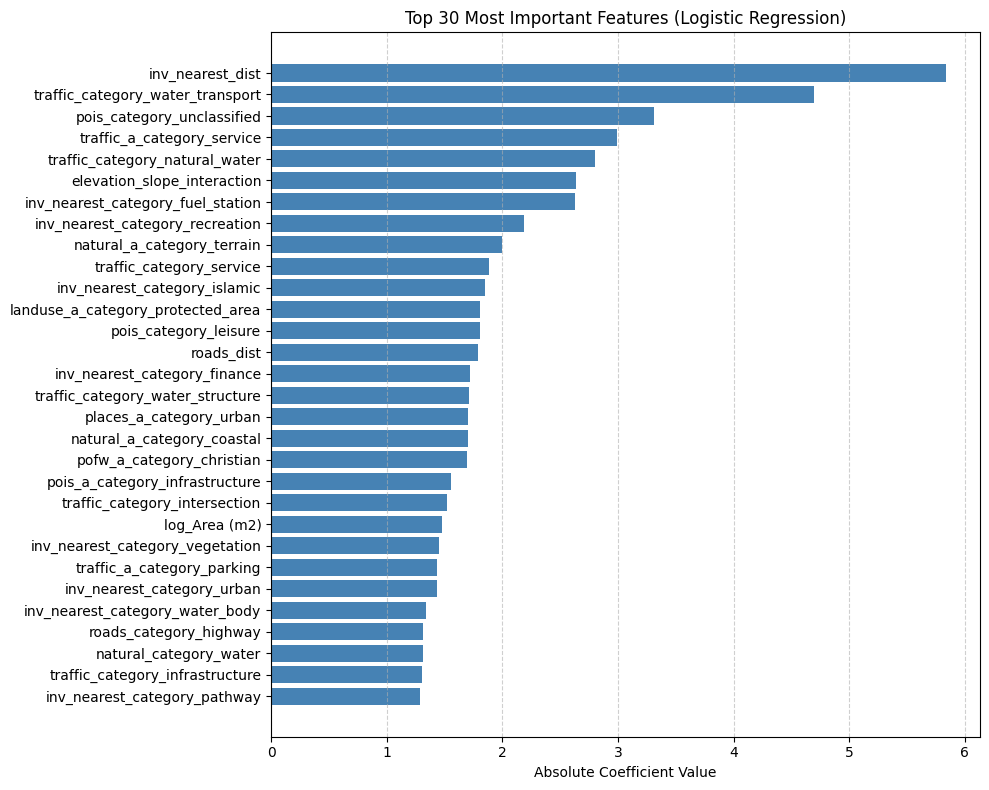

In [2]:
import joblib
import numpy as np
import matplotlib.pyplot as plt

# ---------- Load saved LR pipeline and label encoder ----------
saved = joblib.load("D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/lr_files/final_lr_model_psedo.joblib")
model = saved['model']
le = saved.get('label_encoder', None)

# ---------- Extract pipeline steps ----------
preprocessor = model.named_steps['preprocessor']
classifier = model.named_steps['classifier']  # LogisticRegression

# ---------- Numeric feature names ----------
num_features = preprocessor.transformers_[0][2]  # list of numeric feature names

# ---------- Categorical feature names after one-hot encoding ----------
cat_pipeline = preprocessor.transformers_[1][1]
cat_features_raw = preprocessor.transformers_[1][2]

# Extract one-hot encoder inside categorical pipeline
onehot = cat_pipeline.named_steps['onehot']

# Get categorical feature names after encoding
cat_feature_names = onehot.get_feature_names_out(cat_features_raw)

# Combine numeric and categorical feature names
feature_names = np.array(list(num_features) + list(cat_feature_names))

# ---------- Get feature importances from LR coefficients ----------
# Use absolute value to measure importance
coefs = classifier.coef_[0]  # binary classification -> take first row
importances = np.abs(coefs)

# Sort features by importance descending
top_n = 30
indices = np.argsort(importances)[::-1][:top_n]
top_features = feature_names[indices]
top_importances = importances[indices]

# ---------- Plot horizontal bar chart ----------
plt.figure(figsize=(10, 8))
plt.barh(top_features[::-1], top_importances[::-1], color='steelblue')
plt.xlabel("Absolute Coefficient Value")
plt.title(f"Top {top_n} Most Important Features (Logistic Regression)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [3]:
import fiona
import pandas as pd

rf_path = r"D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/lr_files/LR_final_predictions.gpkg"
pred_col = "Predicted"  

# Open the file without geometry
with fiona.open(rf_path, layer=0) as src:
    # Extract only the prediction column from attributes
    pred_values = [feat["properties"][pred_col] for feat in src]

# Create dataframe from predictions
df = pd.DataFrame(pred_values, columns=[pred_col])

# Count & percentage
counts = df[pred_col].value_counts()
total = len(df)
percent = (counts / total * 100).round(2)

# Summary table
summary = counts.to_frame(name="Count")
summary["Percentage"] = percent

print("\n📊 RF Prediction Summary:")
print(summary)
print("\n🏠 Total Buildings:", total)
print(f"Residential: {counts.get('residential', 0)} ({percent.get('residential', 0)}%)")
print(f"Non-residential: {counts.get('non_residential', 0)} ({percent.get('non_residential', 0)}%)")

if counts.get('non_residential', 0) != 0:
    ratio = counts.get('residential', 0) / counts.get('non_residential', 0)
    print(f"\n📈 Residential to Non-residential Ratio: {ratio:.2f} : 1")



📊 RF Prediction Summary:
                   Count  Percentage
Predicted                           
residential      8307187       75.57
non_residential  2686223       24.43

🏠 Total Buildings: 10993410
Residential: 8307187 (75.57%)
Non-residential: 2686223 (24.43%)

📈 Residential to Non-residential Ratio: 3.09 : 1
